In [32]:
import torch
import torchvision
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms.functional as F

In [33]:
imageW = 1920
imageH = 1080
dummy_img = torch.zeros(1, 3, imageH, imageW).float()
dummy_img

tensor([[[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],

         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]])

# Pass the dummy image through the model and find where the output size matches the downsampled image size


In [34]:

downsampling_factor = 64
downsampled_imageW = imageW // downsampling_factor
downsampled_imageH = imageH // downsampling_factor
model = models.inception_v3(weights=models.Inception_V3_Weights.DEFAULT)
list(model.named_modules())

[('',
  Inception3(
    (Conv2d_1a_3x3): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2a_3x3): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_2b_3x3): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (Conv2d_3b_1x1): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (Conv2d_4a_3x3): BasicConv2d(
      (c

In [35]:
model.eval()
activation = {}

# Capture intermediate outputs
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output
    return hook

hooks = []
for name, module in model.named_modules():
    if isinstance(module, torch.nn.Module) and name != '':  # Skip the root module
        hooks.append(module.register_forward_hook(get_activation(name)))

# Forward pass with dummy image
with torch.no_grad():
    output = model(dummy_img)

for hook in hooks:
    hook.remove()

print(f"Target downsampled size: {downsampled_imageH}x{downsampled_imageW}")
matching_layers = []

for name, feat in activation.items():
    if isinstance(feat, torch.Tensor):
        if len(feat.shape) == 4:  # (batch, channel, height, width)
            height, width = feat.shape[2], feat.shape[3]
            print(f"Layer: {name}, Output shape: {feat.shape}")
            if abs(height - downsampled_imageH) <= 2 and abs(width - downsampled_imageW) <= 2:
                matching_layers.append((name, feat.shape))

print("\nLayers with output size close to target downsampled size:")
for layer, shape in matching_layers:
    print(f"Layer: {layer}, Shape: {shape}")


Target downsampled size: 16x30
Layer: Conv2d_1a_3x3.conv, Output shape: torch.Size([1, 32, 539, 959])
Layer: Conv2d_1a_3x3.bn, Output shape: torch.Size([1, 32, 539, 959])
Layer: Conv2d_1a_3x3, Output shape: torch.Size([1, 32, 539, 959])
Layer: Conv2d_2a_3x3.conv, Output shape: torch.Size([1, 32, 537, 957])
Layer: Conv2d_2a_3x3.bn, Output shape: torch.Size([1, 32, 537, 957])
Layer: Conv2d_2a_3x3, Output shape: torch.Size([1, 32, 537, 957])
Layer: Conv2d_2b_3x3.conv, Output shape: torch.Size([1, 64, 537, 957])
Layer: Conv2d_2b_3x3.bn, Output shape: torch.Size([1, 64, 537, 957])
Layer: Conv2d_2b_3x3, Output shape: torch.Size([1, 64, 537, 957])
Layer: maxpool1, Output shape: torch.Size([1, 64, 268, 478])
Layer: Conv2d_3b_1x1.conv, Output shape: torch.Size([1, 80, 268, 478])
Layer: Conv2d_3b_1x1.bn, Output shape: torch.Size([1, 80, 268, 478])
Layer: Conv2d_3b_1x1, Output shape: torch.Size([1, 80, 268, 478])
Layer: Conv2d_4a_3x3.conv, Output shape: torch.Size([1, 192, 266, 476])
Layer: Conv2

In [36]:
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained InceptionV3
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        
        # Only include the main modules up to Mixed_5d
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d
        )
        
    def forward(self, x):
        return self.feature_extractor(x)

# Create the feature extractor
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval()  # Set to evaluation mode

InceptionFeatureExtractor(
  (feature_extractor): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): BasicConv2d(
      (conv): Conv2d(80, 192, ker

In [37]:
out_dummy_img = feature_extractor(dummy_img)
print(f"Output shape: {out_dummy_img.shape}")
print(f"Number of channels: {out_dummy_img.shape[1]}")
print(f"Spatial dimensions: {out_dummy_img.shape[2]}x{out_dummy_img.shape[3]}")

Output shape: torch.Size([1, 288, 132, 237])
Number of channels: 288
Spatial dimensions: 132x237


Original image size: 1080x1920
Feature map size: 132x237
Downsampling factor H: 8.18
Downsampling factor W: 8.10
Base anchors shape: (9, 4)
Base anchors (y_min, x_min, y_max, x_max) relative to center:
Total number of anchor boxes: 281556
Anchor boxes shape: (281556, 4)


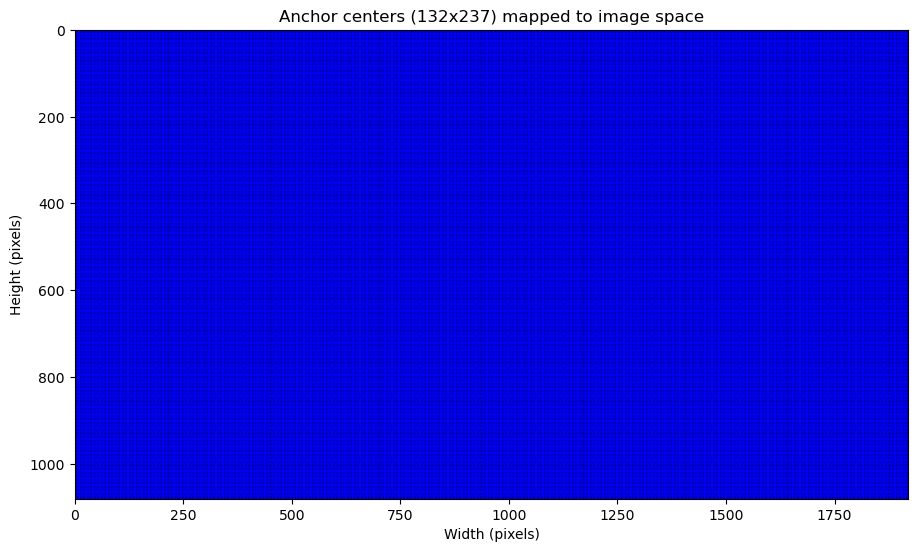

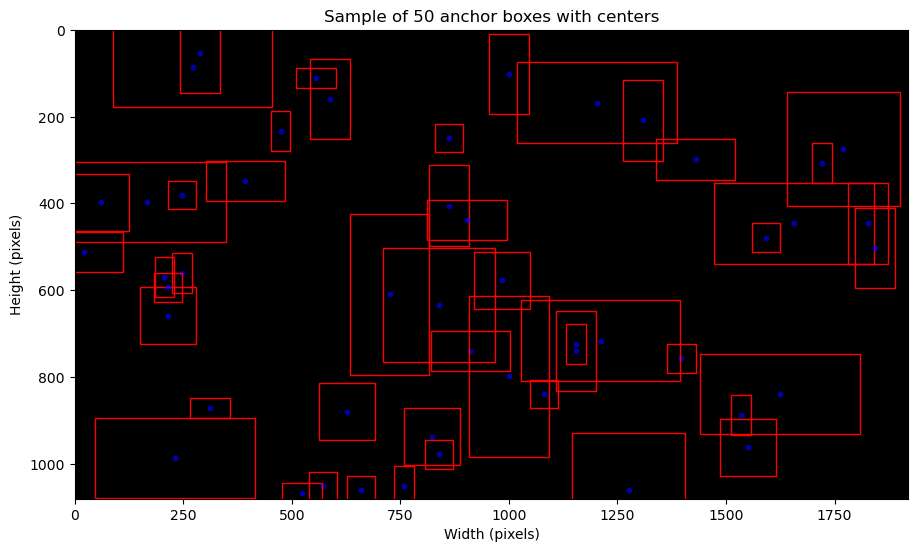

In [41]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

# Define anchor parameters
# These are typical values used in Faster R-CNN
scales = [8, 16, 32]  # Different scales of anchor boxes
aspect_ratios = [0.5, 1.0, 2.0]  # Different aspect ratios (height/width)

# Assume dummy_img and out_dummy_img are defined elsewhere
# --- PLEASE ENSURE THESE ARE DEFINED BEFORE THIS BLOCK ---
# Example shapes (replace with your actual shapes if needed):
# dummy_img = torch.randn(1, 3, 1080, 1920) 
# out_dummy_img = torch.randn(1, 256, 237, 132) # Example feature map output
# --- END OF PLACEHOLDER DEFINITIONS ---


# Calculate the feature map size based on the output of our feature extractor
feature_map_height = out_dummy_img.shape[2]
feature_map_width = out_dummy_img.shape[3]

# Calculate the downsampling factors
original_height, original_width = dummy_img.shape[2], dummy_img.shape[3]
# Use floating point division for potentially more accuracy
downsampling_factor_h = original_height / feature_map_height 
downsampling_factor_w = original_width / feature_map_width
print(f"Original image size: {original_height}x{original_width}")
print(f"Feature map size: {feature_map_height}x{feature_map_width}")
print(f"Downsampling factor H: {downsampling_factor_h:.2f}")
print(f"Downsampling factor W: {downsampling_factor_w:.2f}")

def generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w):
    """
    Generate base anchor boxes for a single feature map location,
    accounting for potentially different downsampling factors for height and width.
    
    Args:
        scales: List of scales for the anchor boxes
        aspect_ratios: List of aspect ratios (height/width) for the anchor boxes
        downsampling_factor_h: Factor by which the original image height was downsampled
        downsampling_factor_w: Factor by which the original image width was downsampled
    
    Returns:
        base_anchors: Tensor of shape (N, 4) where N is the number of anchors
                     and each anchor is represented as (y_min, x_min, y_max, x_max)
                     relative to the center of the receptive field mapped to (0,0).
    """
    # Center of the base anchor in the original image space corresponding to one feature map pixel
    # We define base anchors relative to (0,0) of the mapped receptive field's top-left corner
    ctr_y = downsampling_factor_h / 2.0
    ctr_x = downsampling_factor_w / 2.0
    
    num_anchors = len(scales) * len(aspect_ratios)
    base_anchors = np.zeros((num_anchors, 4), dtype=np.float32)
    
    index = 0
    for scale in scales:
        for ar in aspect_ratios:
            # Calculate height and width based on scale and aspect ratio, 
            # scaling each dimension by its respective downsampling factor.
            # This approach assumes 'scale' is applied somewhat independently to H and W strides.
            h = downsampling_factor_h * scale * np.sqrt(ar)
            w = downsampling_factor_w * scale * np.sqrt(1.0 / ar)

            # y_min, x_min, y_max, x_max relative to the center (ctr_y, ctr_x)
            base_anchors[index, 0] = ctr_y - h / 2.0
            base_anchors[index, 1] = ctr_x - w / 2.0
            base_anchors[index, 2] = ctr_y + h / 2.0
            base_anchors[index, 3] = ctr_x + w / 2.0
            
            index += 1
            
    return base_anchors

def generate_anchor_boxes(feature_map_size, base_anchors, downsampling_factor_h, downsampling_factor_w):
    """
    Generate anchor boxes for all positions in the feature map,
    accounting for potentially different downsampling factors for height and width.
    
    Args:
        feature_map_size: (height, width) of the feature map
        base_anchors: Base anchor boxes for a single location, relative to center.
        downsampling_factor_h: Factor by which the original image height was downsampled
        downsampling_factor_w: Factor by which the original image width was downsampled
    
    Returns:
        anchors: Tensor of shape (N, 4) where N is the number of anchors
                 and each anchor is represented as absolute (y_min, x_min, y_max, x_max)
                 in the original image coordinates.
    """
    height, width = feature_map_size
    
    # Generate top-left coordinates for each feature map location mapped to original image space
    # These shifts correspond to the top-left corner of the receptive field in the original image
    shift_y = np.arange(0, height) * downsampling_factor_h
    shift_x = np.arange(0, width) * downsampling_factor_w
    
    # Create a mesh grid of all combinations of top-left corners
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)
    
    # Combine shifts for y_min, x_min, y_max, x_max. These represent the top-left corner.
    # The base anchors contain coordinates relative to the center of the receptive field (ctr_y, ctr_x).
    # Adding the top-left shift (shift_y, shift_x) to the base anchor coordinates gives the absolute coordinates.
    shifts = np.vstack((
        shift_y.ravel(), shift_x.ravel(),
        shift_y.ravel(), shift_x.ravel()
    )).transpose()
    
    # Number of feature map locations
    A = base_anchors.shape[0]  # Number of anchors per location
    K = shifts.shape[0]  # Number of feature map locations (height * width)
    
    # Broadcast base_anchors to all positions and add shifts
    # anchor = base_anchor + shift
    all_anchors = base_anchors.reshape((1, A, 4)) + shifts.reshape((K, 1, 4))
    all_anchors = all_anchors.reshape((K * A, 4))
    
    return all_anchors

# Generate base anchors for a single location
base_anchors = generate_base_anchors(scales, aspect_ratios, downsampling_factor_h, downsampling_factor_w)
print(f"Base anchors shape: {base_anchors.shape}")
print("Base anchors (y_min, x_min, y_max, x_max) relative to center:")
# print(base_anchors) # Optionally print base anchors

# Generate all anchor boxes
anchors = generate_anchor_boxes(
    (feature_map_height, feature_map_width),
    base_anchors,
    downsampling_factor_h,
    downsampling_factor_w
)

print(f"Total number of anchor boxes: {len(anchors)}")
print(f"Anchor boxes shape: {anchors.shape}")

# Visualize anchor centers on the original image
def visualize_anchor_centers(image_tensor, feature_map_size, downsampling_factor_h, downsampling_factor_w):
    """
    Visualize anchor centers on the original image, accounting for different downsampling factors
    and preserving image aspect ratio in the plot. Plots dots similar to common tutorials.

    Args:
        image_tensor: Original image tensor (B, C, H, W) or (C, H, W)
        feature_map_size: (height, width) of the feature map
        downsampling_factor_h: Factor by which the original image height was downsampled
        downsampling_factor_w: Factor by which the original image width was downsampled
    """
    if image_tensor.dim() == 4: # If batch dimension is present
      img_h, img_w = image_tensor.shape[2], image_tensor.shape[3]
      img_display = image_tensor.squeeze(0) # Remove batch dim for display
    elif image_tensor.dim() == 3: # If no batch dimension
      img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
      img_display = image_tensor
    else:
        raise ValueError("Input image_tensor should have 3 or 4 dimensions (C, H, W) or (B, C, H, W)")

    if img_h == 0: raise ValueError("Image height cannot be zero.")
    aspect_ratio = img_w / img_h

    height, width = feature_map_size

    # Convert image tensor to numpy array for visualization (H, W, C)
    img = img_display.permute(1, 2, 0).cpu().numpy()

    # Normalize image for visualization if needed (handles potential float tensors)
    img_min, img_max = img.min(), img.max()
    if img_max > img_min: # Avoid division by zero if image is flat
        img = (img - img_min) / (img_max - img_min)

    # Adjust figsize based on image aspect ratio
    fig_width = 10 # Base width for the figure in inches
    fig_height = fig_width / aspect_ratio
    plt.figure(figsize=(fig_width, fig_height))

    ax = plt.gca()
    # Use extent to map image display coordinates correctly to data coordinates
    ax.imshow(img, extent=(0, img_w, img_h, 0))

    # Generate centers for each feature map location mapped to original image space
    # Center = top_left + (stride / 2)
    center_y = np.arange(0, height) * downsampling_factor_h + downsampling_factor_h / 2.0
    center_x = np.arange(0, width) * downsampling_factor_w + downsampling_factor_w / 2.0

    # Create a mesh grid of all combinations of centers
    center_x, center_y = np.meshgrid(center_x, center_y)

    # Plot anchor centers as blue dots
    # Explicitly set marker='o' and color='b'
    ax.scatter(center_x, center_y, c='b', s=10, alpha=0.6, marker='o') # Changed color, marker, increased size slightly

    ax.set_title(f'Anchor centers ({height}x{width}) mapped to image space')
    # Set axis limits to match image dimensions, with inverted y-axis common for images
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0)
    ax.set_xlabel("Width (pixels)")
    ax.set_ylabel("Height (pixels)")
    # Ensure the aspect ratio of the plot axes matches the data
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout() # Adjust layout to prevent labels overlapping
    plt.show()

# Remember to call the function after defining it:
# visualize_anchor_centers(dummy_img, (feature_map_height, feature_map_width), downsampling_factor_h, downsampling_factor_w)

# Visualize anchor centers
visualize_anchor_centers(dummy_img, (feature_map_height, feature_map_width), downsampling_factor_h, downsampling_factor_w)

# Visualize some anchor boxes on the original image
def visualize_anchors(image_tensor, anchors, num_to_show=20, show_centers=True):
    """
    Visualize anchor boxes on the original image, adjusting plot aspect ratio.
    
    Args:
        image_tensor: Original image tensor (B, C, H, W) or (C, H, W)
        anchors: Tensor of anchor boxes (N, 4) in format (y_min, x_min, y_max, x_max)
        num_to_show: Number of anchor boxes to visualize
        show_centers: Whether to show anchor centers (default: True)
    """
    if image_tensor.dim() == 4: # If batch dimension is present
      img_h, img_w = image_tensor.shape[2], image_tensor.shape[3]
      img_display = image_tensor.squeeze(0) # Remove batch dim for display
    elif image_tensor.dim() == 3: # If no batch dimension
      img_h, img_w = image_tensor.shape[1], image_tensor.shape[2]
      img_display = image_tensor
    else:
        raise ValueError("Input image_tensor should have 3 or 4 dimensions (C, H, W) or (B, C, H, W)")
        
    aspect_ratio = img_w / img_h

    # Convert image tensor to numpy array for visualization
    img = img_display.permute(1, 2, 0).cpu().numpy()
    
    # Normalize image for visualization if needed
    img_min, img_max = img.min(), img.max()
    if img_max > img_min:
        img = (img - img_min) / (img_max - img_min)
        
    # Adjust figsize based on image aspect ratio
    fig_width = 10
    fig_height = fig_width / aspect_ratio
    plt.figure(figsize=(fig_width, fig_height))
    
    ax = plt.gca()
    # Use extent to map image display coordinates correctly
    ax.imshow(img, extent=(0, img_w, img_h, 0)) 
    
    # Randomly select anchors to visualize
    if len(anchors) > 0:
        indices = np.random.choice(len(anchors), min(num_to_show, len(anchors)), replace=False)
    else:
        indices = []
        print("Warning: No anchors to visualize.")

    # Plot selected anchor boxes
    for idx in indices:
        anchor = anchors[idx]
        y_min, x_min, y_max, x_max = anchor
        width_box = x_max - x_min
        height_box = y_max - y_min
        
        # Create a rectangle patch. Matplotlib Rectangle xy is bottom-left.
        # Since our y-axis is inverted (0 at top), (x_min, y_min) is the correct top-left corner for the patch.
        rect = Rectangle((x_min, y_min), width_box, height_box, 
                         linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)
        
        # If show_centers is True, plot the center of each anchor box
        if show_centers:
            center_x = (x_min + x_max) / 2
            center_y = (y_min + y_max) / 2
            ax.scatter(center_x, center_y, c='b', s=10, alpha=0.6, marker='o')
    
    num_shown = min(num_to_show, len(indices))
    title = f'Sample of {num_shown} anchor boxes'
    if show_centers:
        title += ' with centers'
    ax.set_title(title)
    # Set axis limits to match image dimensions, with inverted y-axis
    ax.set_xlim(0, img_w)
    ax.set_ylim(img_h, 0) 
    ax.set_xlabel("Width (pixels)")
    ax.set_ylabel("Height (pixels)")
    # Ensure the aspect ratio of the plot axes matches the data
    ax.set_aspect('equal', adjustable='box')
    plt.tight_layout() # Adjust layout
    plt.show()

# Visualize a sample of anchor boxes
visualize_anchors(dummy_img, anchors, num_to_show=50) # Increased number shown for better coverage check

In [ ]:
from torchvision.models import inception_v3, Inception_V3_Weights

class InceptionFeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pre-trained InceptionV3
        model = inception_v3(weights=Inception_V3_Weights.DEFAULT, transform_input=True)
        
        # Only include the main modules up to Mixed_5d
        self.feature_extractor = nn.Sequential(
            model.Conv2d_1a_3x3,
            model.Conv2d_2a_3x3,
            model.Conv2d_2b_3x3,
            model.maxpool1,
            model.Conv2d_3b_1x1,
            model.Conv2d_4a_3x3,
            model.maxpool2,
            model.Mixed_5b,
            model.Mixed_5c,
            model.Mixed_5d
        )
        
    def forward(self, x):
        return self.feature_extractor(x)

# Create the feature extractor
feature_extractor = InceptionFeatureExtractor()
feature_extractor.eval()  # Set to evaluation mode

InceptionFeatureExtractor(
  (feature_extractor): Sequential(
    (0): BasicConv2d(
      (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicConv2d(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): BasicConv2d(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): BasicConv2d(
      (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (5): BasicConv2d(
      (conv): Conv2d(80, 192, ker